# Домашнее задание №7. Рекуррентные сети для обработки последовательностей

In [1]:
!pip install stop-words pymorphy2

In [2]:
!pip install torchmetrics

In [3]:
#предобработка
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchmetrics

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Python3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
max_words = 20000
max_len = 10
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

## 0. Загрузка данных

In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech")

Skipping, found downloaded files in ".\twitter-sentiment-analysis-hatred-speech" (use force=True to force download)


In [7]:
# пути к данным
root_data_path = 'twitter-sentiment-analysis-hatred-speech'

dataset_train  = root_data_path + '/train.csv'
dataset_test  = root_data_path + '/test.csv'

In [8]:
#загрузка данных
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [9]:

#тренировочный датасет
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [10]:
#тестовый датасет
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [11]:
#разделение тренировочного датасета на обучающий и валидационный
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [12]:
#датасет для обучения модели
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [13]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [14]:

#датасет для валидации модели
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [15]:
df_valid['label'].value_counts()

0    8905
1     684
Name: label, dtype: int64

## 1. Предобработка данных

In [16]:
#множество стоп-слов
sw = set(stopwords.words('english'))
print(sw)

{'theirs', 'hasn', 'any', 'below', 'of', 'hadn', 'up', 'did', 've', "didn't", 'am', "won't", "doesn't", 'haven', 'shan', 'the', "isn't", 'other', 'y', 'having', "you'd", 'through', 'd', "wasn't", 'about', 'with', 'now', 'wouldn', 'ma', "aren't", 'was', 'against', 'over', 'from', 'just', 'myself', 'been', 'more', 'o', 'once', 'only', 'and', "that'll", 'not', 'she', "should've", 'wasn', 'him', 'doing', 'couldn', "hasn't", 'off', 'yours', 'out', 'into', "you'll", 'he', 'why', 'such', 'before', 'on', 'nor', 'itself', 'being', 'their', 're', 'doesn', 'we', "you've", 'then', 'will', 'same', 'don', "shan't", 'our', 'had', 'each', 'than', 'needn', 'herself', 'during', 'in', 'your', 'all', 'his', 'weren', 'does', "it's", 'again', 't', 'so', 'too', "hadn't", 'at', 'to', 'because', "shouldn't", 'where', 'above', 'are', 'both', 'shouldn', 'ain', 'when', 'these', 'has', 'her', 'own', 'do', 'mustn', 'between', 'if', 'aren', 'didn', 'who', "she's", 'those', 'for', 'whom', 'here', 'them', 'themselves'

In [17]:
#пунктуация
exclude = set(punctuation)
print(exclude)

{'/', '+', '#', '?', '.', ')', '<', '_', '!', '>', ']', '&', '^', '(', '`', '$', '%', '~', '}', ';', '-', "'", ',', '*', '\\', '[', '=', '@', '{', '|', ':', '"'}


In [18]:
#морфологический анализ для английского текста
lemmatizer = WordNetLemmatizer()

#пример работы
lemmatizer.lemmatize('dogs'), lemmatizer.lemmatize('says')

('dog', 'say')

In [19]:
#функция преобразования текста
def preprocess_text(txt):
    #преобразуем входные данные в строку
    txt = str(txt)
    #удяляем знаки пунктуации
    txt = "".join(c for c in txt if c not in exclude)
    #приводим все к нижнему регистру
    txt = txt.lower()
    #лематизация и удаление стоп-слов
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [20]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|█████████████████████████████████████████████████████████████████████████| 17197/17197 [00:00<00:00, 22161.98it/s]


In [21]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [22]:
#токенезация (разбиваем строку на слова)
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [23]:
#отфильтруем токены (проверяем, чтобы все символы были или буквы или цифры)
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

['summer', 'summeriscoming', 'swimming', 'picoftheday', 'tattoo', 'issho', 'pulsera', 'fluyendo', 'dese', 'nigga', 'show', 'dese', 'otha', 'bitch', 'fb', 'snap', 'nd', 'twitter', 'attention', 'dey', 'girl', 'true', 'boost', 'immune', 'system', 'allow', 'body', 'use', 'energy', 'reading', 'manuscript', 'wanting', 'stop', 'good', 'evening', 'good', 'night', 'baby', 'say', 'hate', 'today', 'im', 'dj', 'lol', 'womanofmanyhats', 'instamood', 'love', 'silentdisco', 'christmas', 'eve', 'christmas', 'adam', 'towards', 'men', 'feminism', 'lover', 'stop', 'angry', 'visit', 'usgtgtgt', 'lover', 'friend', 'astrologer', 'love', 'best', 'wish', 'outside', 'gym', 'fitness', 'macboys', 'blue', 'white', 'grey', 'user', 'stress', 'pretty', 'ditch', 'laugh', 'exercise', 'headisease', 'user', 'user', 'user', 'creative', 'sent', 'user', 'thebigscreen', 'user', 'weekend', 'thankful', 'coffee', 'thankful', 'positive', 'user', 'whisky', 'connoisseur', 'kit', 'fathersday', 'whisky', 'make', 'innovativenous', '

In [24]:
#соберем max_words наиболее частых токенов

#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12209, 'love': 1886, 'day': 1875, 'happy': 1183, 'u': 1161, 'amp': 1099, 'time': 851, 'life': 844, 'im': 785, 'today': 742, ...})

In [25]:
#берем max_words наиболее часто встречающихся токенов
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(19999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [26]:
#словарь слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top,1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'happy': 4,
 'u': 5,
 'amp': 6,
 'time': 7,
 'life': 8,
 'im': 9,
 'today': 10,
 'like': 11,
 'new': 12,
 'get': 13,
 'positive': 14,
 'thankful': 15,
 'father': 16,
 'make': 17,
 'good': 18,
 'people': 19,
 'one': 20,
 'bihday': 21,
 'cant': 22,
 'go': 23,
 'smile': 24,
 'see': 25,
 'want': 26,
 'friend': 27,
 'dont': 28,
 'take': 29,
 'work': 30,
 'weekend': 31,
 'healthy': 32,
 'girl': 33,
 'got': 34,
 'need': 35,
 'fun': 36,
 'week': 37,
 'family': 38,
 'way': 39,
 'summer': 40,
 'great': 41,
 'friday': 42,
 'best': 43,
 '2': 44,
 'beautiful': 45,
 'bull': 46,
 'going': 47,
 'year': 48,
 'wait': 49,
 'know': 50,
 'thing': 51,
 'first': 52,
 'really': 53,
 'music': 54,
 'back': 55,
 'morning': 56,
 'world': 57,
 'home': 58,
 'think': 59,
 'look': 60,
 'come': 61,
 'feel': 62,
 'affirmation': 63,
 'dad': 64,
 'tomorrow': 65,
 'cute': 66,
 'fathersday': 67,
 'orlando': 68,
 'never': 69,
 'sad': 70,
 'trump': 71,
 'night': 72,
 'happiness': 73,
 'muc

In [27]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [28]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]], dtype=np.int32)

x_train.shape, x_valid.shape, x_test.shape

((22373, 10), (9589, 10), (17197, 10))

In [29]:
#данные после подготовки к обучению
torch.from_numpy(x_train[0])

tensor([   40,  6950,  1094,   581,  1376, 10733, 10734,  6951,     0,     0],
       dtype=torch.int32)

## 2. Dataset и Dataloader

In [30]:
#Датасет
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [31]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [32]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 10]) tensor([    6,     6,  2594, 19984, 19985,    86,   311,   622, 19986,  9669])
torch.Size([512]) tensor(0)


## 3. Построение и обучение модели LSTM

In [33]:

#LSTM
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 
        # lstm_out: тензор с выходными фичами с последнего слоя для каждого t #(B, L, Hout)
        # h_t: тензор с последними скрытыми состояниями по слоям  #(num_layers, B, Hout)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]  #(B, Hout) тензор с последней строкой из каждого батча
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)  #(B, Hout) тензор со средним арифметическим столбцов по каждому батчу
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [34]:
#инициализация модели
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(model_lstm)
print("Parameters:", sum([param.nelement() for param in model_lstm.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2824321


In [35]:
#компиляция модели
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [36]:
%%time

#обучение модели
model_lstm.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_lstm = []
valid_acc_history_lstm = []
train_acc = torchmetrics.Accuracy(task = 'binary')
test_acc = torchmetrics.Accuracy(task = 'binary')

for epoch in range(epochs): 
    model_lstm.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_lstm.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_lstm(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)

    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_lstm.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.222. Acc: 0.863. Test loss: 0.077. Test acc: 0.932
Epoch [2/10]. Step [44/44]. Loss: 0.158. Acc: 0.938. Test loss: 0.042. Test acc: 0.940
Epoch [3/10]. Step [44/44]. Loss: 0.154. Acc: 0.945. Test loss: 0.038. Test acc: 0.944
Epoch [4/10]. Step [44/44]. Loss: 0.135. Acc: 0.952. Test loss: 0.015. Test acc: 0.947
Epoch [5/10]. Step [44/44]. Loss: 0.090. Acc: 0.958. Test loss: 0.018. Test acc: 0.950
Epoch [6/10]. Step [44/44]. Loss: 0.143. Acc: 0.965. Test loss: 0.014. Test acc: 0.953
Epoch [7/10]. Step [44/44]. Loss: 0.085. Acc: 0.971. Test loss: 0.001. Test acc: 0.954
Epoch [8/10]. Step [44/44]. Loss: 0.042. Acc: 0.978. Test loss: 0.001. Test acc: 0.952
Epoch [9/10]. Step [44/44]. Loss: 0.054. Acc: 0.983. Test loss: 0.203. Test acc: 0.955
Epoch [10/10]. Step [44/44]. Loss: 0.033. Acc: 0.985. Test loss: 0.000. Test acc: 0.954
Training is finished!
CPU times: total: 3min 14s
Wall time: 2min 51s


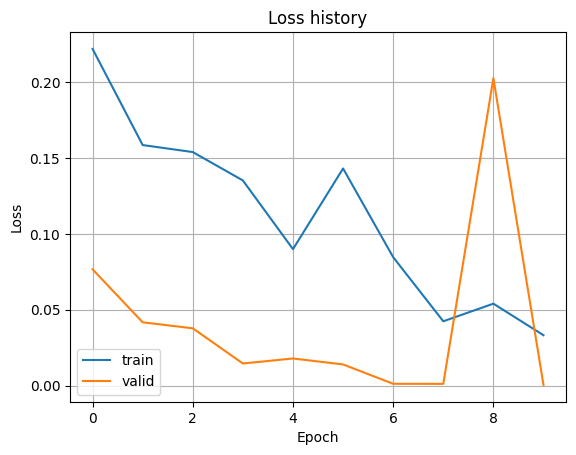

In [39]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

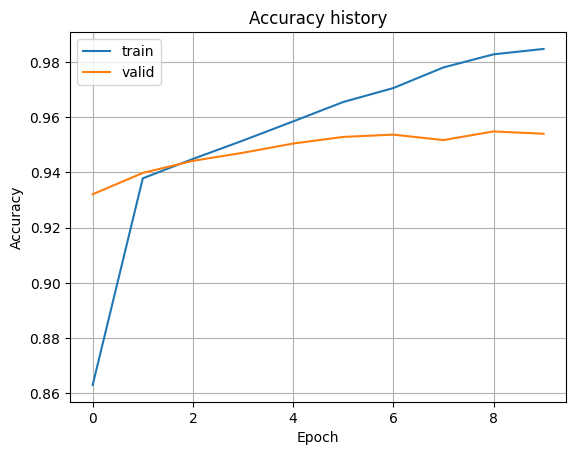

In [40]:
#визуализации метрики
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_lstm, label='train')
plt.plot(valid_acc_history_lstm, label='valid')
plt.legend()

## 4. Построение и обучение модели GRU

In [41]:
#GRU
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        gru_out, ht = self.gru(x) 
        # gru_out: тензор с выходными фичами с последнего слоя для каждого t #(B, L, Hout)
        # h_t: тензор с последними скрытыми состояниями по слоям  #(num_layers, B, Hout)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]  #(B, Hout) тензор с последней строкой из каждого батча
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)  #(B, Hout) тензор со средним арифметическим столбцов по каждому батчу
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [42]:
#инициализация модели
model_gru = GRUFixedLen(max_words, 128, 128, use_last=False)
print(model_gru)
print("Parameters:", sum([param.nelement() for param in model_gru.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2758273


In [43]:
#компиляция модели
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [44]:
%%time

#обучение модели
model_gru.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_gru = []
valid_acc_history_gru = []

train_acc = torchmetrics.Accuracy('binary')
test_acc = torchmetrics.Accuracy('binary')

for epoch in range(epochs):  
    model_gru.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_gru.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_gru.append(train_acc.compute().item())
    train_acc.reset()
    

    # выводим статистику на тестовых данных

    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_gru(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)
    
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_gru.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.234. Acc: 0.910. Test loss: 0.047. Test acc: 0.935
Epoch [2/10]. Step [44/44]. Loss: 0.191. Acc: 0.940. Test loss: 0.153. Test acc: 0.942
Epoch [3/10]. Step [44/44]. Loss: 0.190. Acc: 0.948. Test loss: 0.328. Test acc: 0.946
Epoch [4/10]. Step [44/44]. Loss: 0.144. Acc: 0.956. Test loss: 0.032. Test acc: 0.950
Epoch [5/10]. Step [44/44]. Loss: 0.132. Acc: 0.962. Test loss: 0.467. Test acc: 0.953
Epoch [6/10]. Step [44/44]. Loss: 0.132. Acc: 0.968. Test loss: 0.100. Test acc: 0.955
Epoch [7/10]. Step [44/44]. Loss: 0.069. Acc: 0.973. Test loss: 0.002. Test acc: 0.956
Epoch [8/10]. Step [44/44]. Loss: 0.061. Acc: 0.978. Test loss: 0.966. Test acc: 0.957
Epoch [9/10]. Step [44/44]. Loss: 0.054. Acc: 0.982. Test loss: 0.001. Test acc: 0.956
Epoch [10/10]. Step [44/44]. Loss: 0.041. Acc: 0.984. Test loss: 0.067. Test acc: 0.955
Training is finished!
CPU times: total: 2min 40s
Wall time: 2min 14s


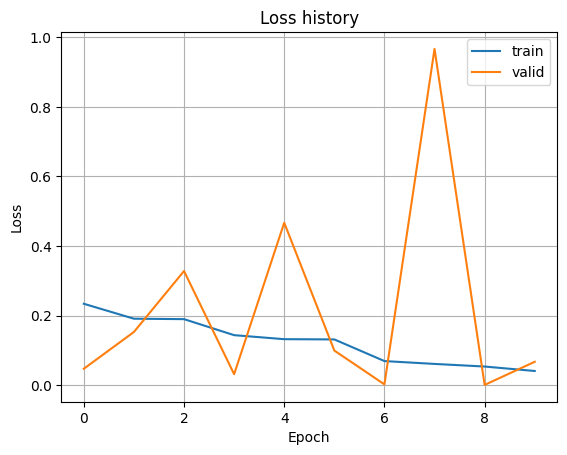

In [45]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

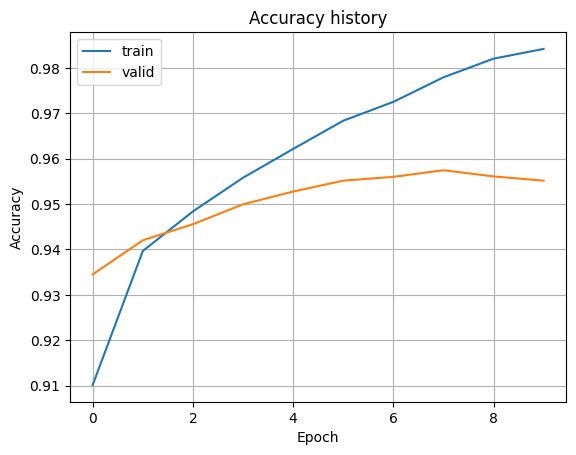

In [46]:
#визуализации метрики
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_gru, label='train')
plt.plot(valid_acc_history_gru, label='valid')
plt.legend()

## 5. Выводы

In [47]:
# сводная таблица метрик моделей
metrics_result = pd.DataFrame([{'Acc_train': train_acc_history_lstm[-1], 
                                'Acc_test': valid_acc_history_lstm[-1]},
                               {'Acc_train':  train_acc_history_gru[-1],
                                'Acc_test': valid_acc_history_gru[-1]}],
                              index =['LSTM', 'GRU'], 
                              columns =['Acc_train', 'Acc_test'])

metrics_result.sort_values(by='Acc_test', ascending=False)

,Acc_train,Acc_test
GRU,0.984177,0.955157
LSTM,0.984714,0.954010


Выводы:

- Поскольку метрика на валидации растет немонотонно, то увеличение числа эпох не способствует росту метрик на валидации.

- Увеличение embedding_dim приводит к росту метрик на валидации.

- Увеличение hidden_dim способствует росту метрики на валидации.

- Увеличение max_words влечет увеличение метрики на валидации.

- При уменьшении max_len метрика на валидации растет.

- Пункты 2-4 увеличивают время обучения.

- При одних и тех же гиперпараметрах GRU обучается быстрее, чем LSTM. При этом метрики моделей примерно одинаковы.